# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data**

## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [35]:
import os
import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader

# Check if CUDA is available (for GPU usage)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)


Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [2]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # The number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS,
# then there is no overlap between the segments
STEP_DISTANCE = 40

#print('torch version ', torch.__version__)


# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [36]:
# Define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None, names=column_names)
    # Last column has a ";" character which must be removed
    df['z-axis'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    # Transform 'z-axis' column to float
    df['z-axis'] = df['z-axis'].apply(convert_to_float)

    df.dropna(axis=0, how='any', inplace=True)  # Drop NaN values

    return df

def convert_to_float(x):
    try:
        return np.float32(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):
    # Shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))


The data can be downloaded from **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

Then 'file_path' the directory to where you have put the data.

In [37]:
file_path = '../data/WISDM_ar_v1.1_raw.txt'
df = read_data(file_path)

In [38]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1098208
Number of columns in the dataframe: 6


,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


In [39]:
LABEL = 'ActivityEncoded' # from 0 to 5

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [40]:
# Split data into train and test set
# train: user 1 ~ 28
# test: user 28 ~

df_train = df[df['user'] <= 28]
df_test = df[df['user'] > 28]

In [41]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()


# round numbers
df_train = df_train.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})
df_train.head()

,user,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshape it.

In [42]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3

    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments

    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]

        # find the most often used label in this segment
        label_mode_result = stats.mode(df[label_name][i: i + time_steps])
        if np.isscalar(label_mode_result.mode):
            label = label_mode_result.mode
        else:
            label = label_mode_result.mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [43]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [44]:
input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input shape:', input_shape)

x_train shape: (20868, 240)
input shape: 240


In [45]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [46]:
# This function transforms integer y classes into one-hot-encoded vectors
def to_categorical(y, num_classes):
    return torch.eye(num_classes)[y]

n_classes = len(np.unique(y_train))  # Assuming y_train is available and contains your class labels
y_train_hot = to_categorical(y_train, n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  torch.Size([20868, 6])


---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.


This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).


In [47]:
# Define 3 DataLoader : train, validation and test
np.random.seed(42)

from torch.utils.data import random_split

# Convert your numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # long for CrossEntropyLoss
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Define validation dataset
total_train_size = len(train_dataset)
train_size = int(0.8 * total_train_size)
val_size = total_train_size - train_size

# Redefine train and validation TensorDatasets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 400  # You can change this value as per your need : number of samples that will be processed in each iteration during training or testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
# Redefine the model with hyperparameters tuned
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes, 
                 nb_conv_layers = 5, activation_function = nn.ReLU(), 
                 pooling = "avg", kernel_size = 5, stride = 1):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes
        self.nb_conv_layers = nb_conv_layers
        self.activation_function = activation_function
        self.pooling = pooling
        self.kernel_size = kernel_size
        self.stride = stride

        # Input size for the first linear layer
        input_size = self.n_sensors

        # Create hidden layers with ReLU activation
        self.conv_layers = nn.ModuleList() # creates a list of layers
        for layer in range(nb_conv_layers):
            if layer <= 1:
                self.conv_layers.append(nn.Conv1d(input_size, 100,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride,
                                                  padding = 5))
                #self.conv_layers.append(nn.BatchNorm1d(100))
                self.conv_layers.append(activation_function)
                input_size = 100 # Update input size for the next layer
            else :
                self.conv_layers.append(nn.Conv1d(input_size, 160,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride,
                                                  padding = 5))
                #self.conv_layers.append(nn.BatchNorm1d(160))
                self.conv_layers.append(activation_function)
                input_size = 160 # Update input size for the next layer

        # Pooling and dropout
        if pooling == "max":
            self.pool = nn.MaxPool1d(kernel_size=3)
        else :
            self.pool = nn.AvgPool1d(kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

        # Batch normalization
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.batchnorm2 = nn.BatchNorm1d(100)
        self.batchnorm3 = nn.BatchNorm1d(160)
        self.batchnorm4 = nn.BatchNorm1d(160)
        self.batchnorm5 = nn.BatchNorm1d(160)

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x_batch_size = x.size(0)
        x = x.reshape(x_batch_size, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)

            # Batch normalization
            if i==0:
                #print("layernorm")
                x = self.batchnorm1(x)
            elif i==2:
                #print("layernorm")
                x = self.batchnorm2(x)
            elif i==4:
                #print("layernorm")
                x = self.batchnorm3(x)
            elif i==6:
                #print("layernorm")
                x = self.batchnorm4(x)
            elif i==8:
                #print("layernorm")
                x = self.batchnorm5(x)

            # Pooling every 2 layers
            if i % 4 == 0 and i != 0 and i < len(self.conv_layers)-1:
                x = self.pool(x)

        # Global average pooling and dropout
        x = self.avgpool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.reshape(x_batch_size, -1)

        # Output layer with softmax activation
        x = self.fc(x)

        # output the loss, Use log_softmax for numerical stability
        x = F.log_softmax(x, dim=1)
        return x
    
    def predict(self, x):
        self.eval()

        # Convert numpy array to PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Perform forward pass to get predictions
        with torch.no_grad():
          x_tensor = x_tensor.to(device)
          probabilities = self.forward(x_tensor)

        return probabilities.cpu().numpy()

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

MyConvModel(
  (activation_function): ReLU()
  (conv_layers): ModuleList(
    (0): Conv1d(3, 100, kernel_size=(5,), stride=(1,), padding=(5,))
    (1): ReLU()
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(5,))
    (3): ReLU()
    (4): Conv1d(100, 160, kernel_size=(5,), stride=(1,), padding=(5,))
    (5): ReLU()
    (6): Conv1d(160, 160, kernel_size=(5,), stride=(1,), padding=(5,))
    (7): ReLU()
    (8): Conv1d(160, 160, kernel_size=(5,), stride=(1,), padding=(5,))
    (9): ReLU()
  )
  (pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (dropout): Dropout(p=0.5, inplace=False)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_runni

In [49]:
# Use Pytorch's cross entropy Loss function for a classification task
criterion = nn.CrossEntropyLoss()

In [50]:
#BATCH_SIZE = 400
EPOCHS = 200

# Optimizer
my_optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
best_val_loss = float('inf')
patience = 100
trigger_times = 0

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train_cnn(model, device, num_epochs, my_optimizer):
    # Initialize lists to store losses and accuracies
    global train_losses, val_losses, train_accs, val_accs, best_val_loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            my_optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            my_optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = correct_train/total_train
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(train_acc)

        # Validation
        val_acc, val_loss = validate_cnn(model, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print the metrics during training (every 50 epochs)
        if epoch % 25 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_acc:.4f}, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
                break

    return train_losses, val_losses, train_accs, val_accs

def validate_cnn(model, device):
    #raise NotImplementedError
    model.eval()
    running_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val/total_val
    val_loss = running_loss/len(val_loader)
    return(val_acc, val_loss)

In [20]:
print('Training the model...')

train_cnn(model_cnn, device, EPOCHS, my_optimizer)
validate_cnn(model_cnn, device)

Training the model...
Epoch [1/200], Training Loss: 0.5534, Training Accuracy: 0.8229, Validation Loss: 0.5707, Validation Accuracy: 0.8230
Epoch [26/200], Training Loss: 0.0103, Training Accuracy: 0.9972, Validation Loss: 0.0534, Validation Accuracy: 0.9854
Epoch [51/200], Training Loss: 0.0111, Training Accuracy: 0.9969, Validation Loss: 0.0857, Validation Accuracy: 0.9758
Epoch [76/200], Training Loss: 0.0017, Training Accuracy: 0.9995, Validation Loss: 0.0374, Validation Accuracy: 0.9911
Epoch [101/200], Training Loss: 0.0015, Training Accuracy: 0.9998, Validation Loss: 0.0370, Validation Accuracy: 0.9902
Epoch [126/200], Training Loss: 0.0011, Training Accuracy: 0.9998, Validation Loss: 0.0400, Validation Accuracy: 0.9904
Epoch [151/200], Training Loss: 0.0014, Training Accuracy: 0.9998, Validation Loss: 0.0347, Validation Accuracy: 0.9914
Early stopping triggered after 167 epochs without improvement.


(0.9858648778150455, 0.06180768680166115)

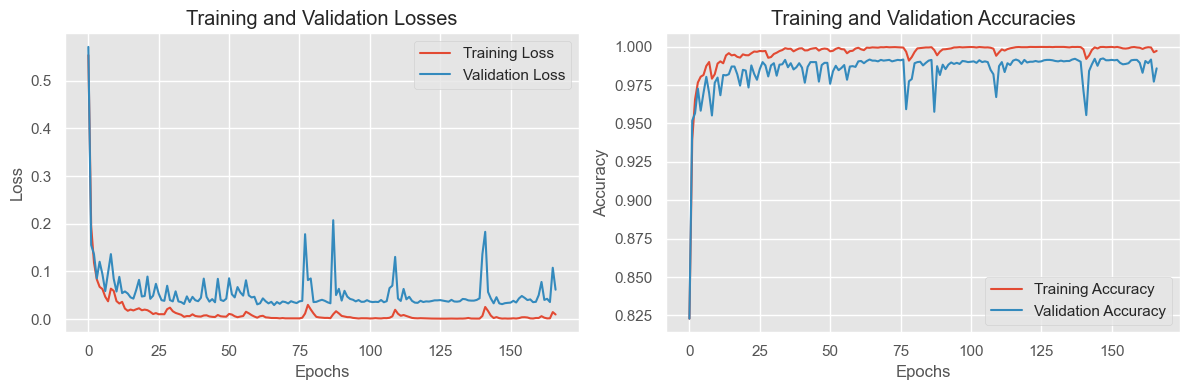

In [26]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses):
    # Plot losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.tight_layout() # prevent overlapping of subplots
    plt.savefig("../images/CNN_normalization/CNN_batch_valtrainslosses.png")
    plt.show()

plot_performance(train_losses, val_losses)

In [27]:
test_losses = []
test_accs = []

def validate_cnn_test(model, device):
    #raise NotImplementedError
    global test_losses, test_accs
    model.eval()
    running_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = correct_test/total_test
    test_loss = running_loss/len(test_loader)
    return(test_acc, test_loss)

test_accs, test_losses = validate_cnn_test(model_cnn, device)

In [28]:
# normalize test data
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = to_categorical(y_test, n_classes)

print('Accuracy on test data: ', test_accs) # Final value of the list
print('Loss on test data: ', test_losses)

Accuracy on test data:  0.3019441069258809
Loss on test data:  342.54369623520796


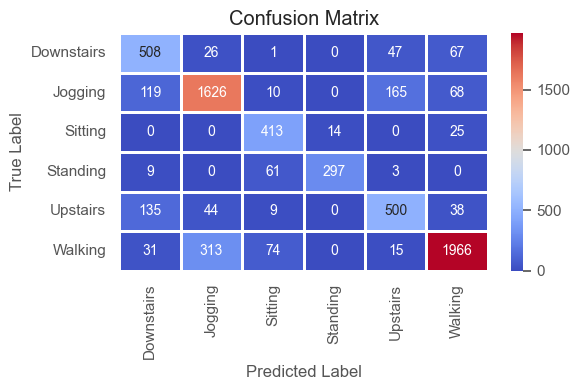

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       649
           1       0.81      0.82      0.81      1988
           2       0.73      0.91      0.81       452
           3       0.95      0.80      0.87       370
           4       0.68      0.69      0.69       726
           5       0.91      0.82      0.86      2399

    accuracy                           0.81      6584
   macro avg       0.79      0.80      0.79      6584
weighted avg       0.82      0.81      0.81      6584



In [29]:
# Confusion matrix on test set
def show_confusion_matrix(validations, predictions, title=None):
    matrix = metrics.confusion_matrix(validations, predictions)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig("../images/CNN_normalization/CNN_batch_confusionmatrix_test.png")
    plt.show()

y_pred_test = model_cnn.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(max_y_test, max_y_pred_test)

0.8065006075334143

In [51]:
# Redefine the model with hyperparameters tuned : layer norm
class MyConvModel(nn.Module):
    def __init__(self, time_periods, n_sensors, n_classes, input_shape = [400, 3, 80],
                 nb_conv_layers = 5, activation_function = nn.ReLU(), 
                 pooling = "avg", kernel_size = 5, stride = 1):
        super(MyConvModel, self).__init__()
        self.time_periods = time_periods
        self.n_sensors = n_sensors
        self.n_classes = n_classes
        self.nb_conv_layers = nb_conv_layers
        self.activation_function = activation_function
        self.pooling = pooling
        self.kernel_size = kernel_size
        self.stride = stride

        # Input size for the first linear layer
        input_size = self.n_sensors

        # Create hidden layers with ReLU activation
        self.conv_layers = nn.ModuleList() # creates a list of layers
        for layer in range(nb_conv_layers):
            if layer <= 1:
                self.conv_layers.append(nn.Conv1d(input_size, 100,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride,
                                                  padding = 5))
                input_size = 100 # Update input size for the next layer  
                #input_shape = [input_shape[0], input_size, (input_shape[2]-kernel_size+2*5) // stride + 1]
                self.conv_layers.append(activation_function)
            else :
                self.conv_layers.append(nn.Conv1d(input_size, 160,
                                                  kernel_size = self.kernel_size,
                                                  stride = self.stride,
                                                  padding = 5))
                input_size = 160 # Update input size for the next layer
                #input_shape = [input_shape[0], input_size, (input_shape[2]-kernel_size+2*5) // stride + 1]
                #self.conv_layers.append(nn.LayerNorm([input_size, input_shape[2]]))
                self.conv_layers.append(activation_function)

        # Pooling and dropout
        if pooling == "max":
            self.pool = nn.MaxPool1d(kernel_size=3)
        else :
            self.pool = nn.AvgPool1d(kernel_size=3)
        self.dropout = nn.Dropout(0.5)

        # Adaptive pool layer to adjust the size before sending to fully connected layer
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(160, n_classes)

        # Layer norm
        self.layernorm1 = nn.LayerNorm([100, 86])
        self.layernorm2 = nn.LayerNorm([100, 92])
        self.layernorm3 = nn.LayerNorm([160, 98])
        self.layernorm4 = nn.LayerNorm([160, 38])
        self.layernorm5 = nn.LayerNorm([160, 44])
        #self.conv_layers.append(nn.LayerNorm([input_size, input_shape[2]]))

        #raise NotImplementedError

    def forward(self, x):
        # Reshape the input to (batch_size, n_sensors, time_periods)
        x_batch_size = x.size(0)
        x = x.reshape(x_batch_size, self.n_sensors, self.time_periods)

        # Convolutional layers with ReLU activations
        for i, layer in enumerate(self.conv_layers):
            #print(layer)
            x = layer(x)

            # Layer normalization
            if i==0:
                #print("layernorm")
                x = self.layernorm1(x)
            elif i==2:
                #print("layernorm")
                x = self.layernorm2(x)
            elif i==4:
                #print("layernorm")
                x = self.layernorm3(x)
            elif i==6:
                #print("layernorm")
                x = self.layernorm4(x)
            elif i==8:
                #print("layernorm")
                x = self.layernorm5(x)

            #print(x.shape)
            # Pooling every 2 layers
            if i % 4 == 0 and i != 0 and i < len(self.conv_layers)-1:
                #print("pool")
                #print(i)
                x = self.pool(x)
                #print(x.shape)
        #print("end")

        # Global average pooling and dropout
        x = self.avgpool(x)
        x = self.dropout(x)

        # Flatten the tensor for the fully connected layer
        x = x.reshape(x_batch_size, -1)

        # Output layer with softmax activation
        x = self.fc(x)

        # output the loss, Use log_softmax for numerical stability
        x = F.log_softmax(x, dim=1)
        return x
    
    def predict(self, x):
        self.eval()

        # Convert numpy array to PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)

        # Perform forward pass to get predictions
        with torch.no_grad():
          x_tensor = x_tensor.to(device)
          probabilities = self.forward(x_tensor)

        return probabilities.cpu().numpy()

# Assuming TIME_PERIODS, n_sensors, and n_classes are defined
model_cnn = MyConvModel(TIME_PERIODS, n_sensors, n_classes)

# Move the model to the device (CPU or GPU)
model_cnn.to(device)

# Print model summary
print(model_cnn)

MyConvModel(
  (activation_function): ReLU()
  (conv_layers): ModuleList(
    (0): Conv1d(3, 100, kernel_size=(5,), stride=(1,), padding=(5,))
    (1): ReLU()
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(5,))
    (3): ReLU()
    (4): Conv1d(100, 160, kernel_size=(5,), stride=(1,), padding=(5,))
    (5): ReLU()
    (6): Conv1d(160, 160, kernel_size=(5,), stride=(1,), padding=(5,))
    (7): ReLU()
    (8): Conv1d(160, 160, kernel_size=(5,), stride=(1,), padding=(5,))
    (9): ReLU()
  )
  (pool): AvgPool1d(kernel_size=(3,), stride=(3,), padding=(0,))
  (dropout): Dropout(p=0.5, inplace=False)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=160, out_features=6, bias=True)
  (layernorm1): LayerNorm((100, 86), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((100, 92), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((160, 98), eps=1e-05, elementwise_affine=True)
  (layernorm4): LayerNorm((160, 38), eps=1e-05, elementwi

In [52]:
#BATCH_SIZE = 400
EPOCHS = 200

# Optimizer
my_optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
best_val_loss = float('inf')
patience = 100
trigger_times = 0

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

def train_cnn(model, device, num_epochs, my_optimizer):
    # Initialize lists to store losses and accuracies
    global train_losses, val_losses, train_accs, val_accs, best_val_loss

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            my_optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            my_optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = correct_train/total_train
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(train_acc)

        # Validation
        val_acc, val_loss = validate_cnn(model, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print the metrics during training (every 50 epochs)
        if epoch % 25 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_acc:.4f}, '
                  f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs without improvement.')
                break

    return train_losses, val_losses, train_accs, val_accs

def validate_cnn(model, device):
    #raise NotImplementedError
    model.eval()
    running_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val/total_val
    val_loss = running_loss/len(val_loader)
    return(val_acc, val_loss)

In [1]:
(201+1792+412+270+425+2023)/6584

0.7780984204131227

In [53]:
print('Training the model...')

train_cnn(model_cnn, device, EPOCHS, my_optimizer)
validate_cnn(model_cnn, device)

Training the model...
Epoch [1/200], Training Loss: 0.9776, Training Accuracy: 0.6678, Validation Loss: 0.6277, Validation Accuracy: 0.7911
Epoch [26/200], Training Loss: 0.0258, Training Accuracy: 0.9925, Validation Loss: 0.0493, Validation Accuracy: 0.9832
Epoch [51/200], Training Loss: 0.0084, Training Accuracy: 0.9974, Validation Loss: 0.0786, Validation Accuracy: 0.9794
Epoch [76/200], Training Loss: 0.0249, Training Accuracy: 0.9923, Validation Loss: 0.0534, Validation Accuracy: 0.9847
Epoch [101/200], Training Loss: 0.0016, Training Accuracy: 0.9998, Validation Loss: 0.0453, Validation Accuracy: 0.9887
Epoch [126/200], Training Loss: 0.0021, Training Accuracy: 0.9996, Validation Loss: 0.0552, Validation Accuracy: 0.9883
Early stopping triggered after 148 epochs without improvement.


(0.986823191183517, 0.054688846015117386)

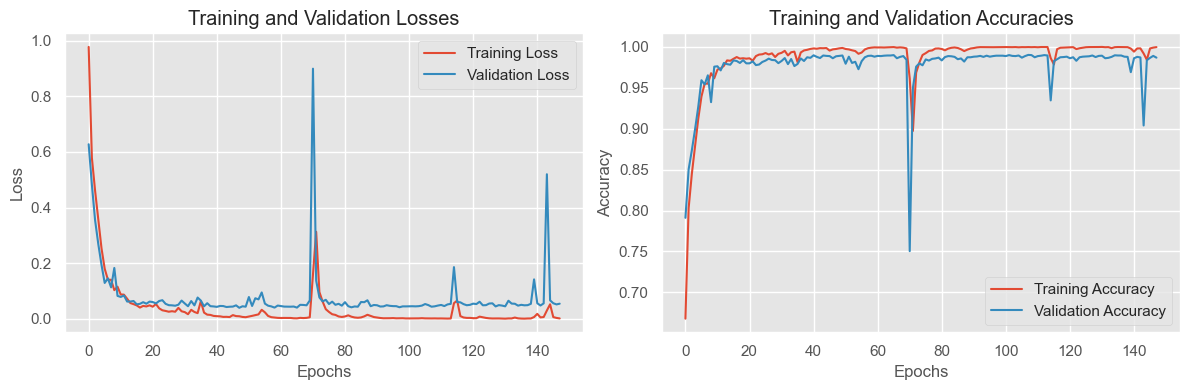

In [54]:
# Losses and accuracy plots
def plot_performance(train_losses, val_losses):
    # Plot losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()

    plt.tight_layout() # prevent overlapping of subplots
    plt.savefig("../images/CNN_normalization/CNN_layer_valtrainslosses.png")
    plt.show()

plot_performance(train_losses, val_losses)

In [55]:
test_losses = []
test_accs = []

def validate_cnn_test(model, device):
    #raise NotImplementedError
    global test_losses, test_accs
    model.eval()
    running_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_acc = correct_test/total_test
    test_loss = running_loss/len(test_loader)
    return(test_acc, test_loss)

test_accs, test_losses = validate_cnn_test(model_cnn, device)

In [56]:
# normalize test data
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis':4, 'y-axis':4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = to_categorical(y_test, n_classes)

print('Accuracy on test data: ', test_accs) # Final value of the list
print('Loss on test data: ', test_losses)

Accuracy on test data:  0.3324726609963548
Loss on test data:  8.919383792316212


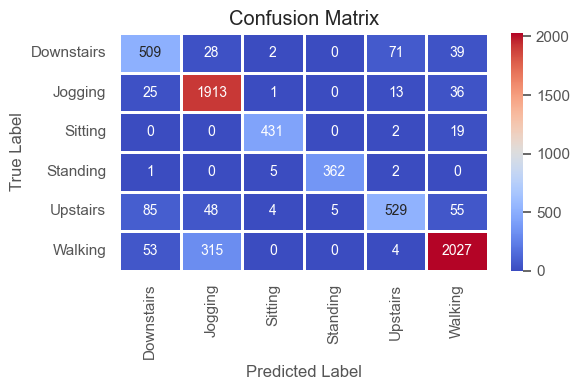

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       649
           1       0.83      0.96      0.89      1988
           2       0.97      0.95      0.96       452
           3       0.99      0.98      0.98       370
           4       0.85      0.73      0.79       726
           5       0.93      0.84      0.89      2399

    accuracy                           0.88      6584
   macro avg       0.89      0.88      0.88      6584
weighted avg       0.88      0.88      0.88      6584



In [57]:
# Confusion matrix on test set
def show_confusion_matrix(validations, predictions, title=None):
    matrix = metrics.confusion_matrix(validations, predictions)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title)
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig("../images/CNN_normalization/CNN_layer_confusionmatrix_test.png")
    plt.show()

y_pred_test = model_cnn.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))